In [145]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

In [146]:
df=pd.read_csv('../datos/salarios_encoding_dum.csv', index_col=0)
df.head(2) #Hacemos una vista previa de nuestro DataFrame

,salary_box,experience_levelmap_funcion,emp_resid_CA,emp_resid_ES,emp_resid_FR,emp_resid_GB,emp_resid_IN,emp_resid_US
0,4631.904560,1,0,0,0,0,0,1
1,7311.922975,2,0,0,0,0,0,1


En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:

- Ajustar el modelo a un Decision Tree
- Extraer las métricas
- Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [147]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.drop("salary_box", axis = 1)
y = df["salary_box"]

In [148]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Ajustamos el módelo

In [149]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

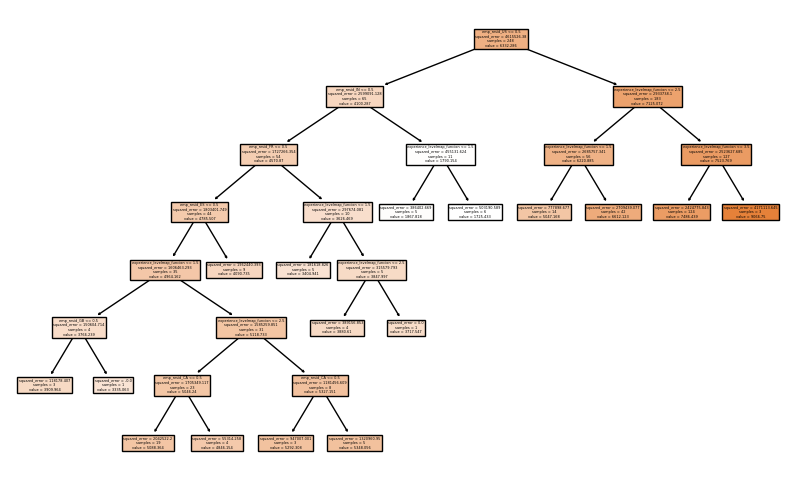

In [150]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

In [151]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 3.
max_features = np.sqrt(len(x_train.columns))
max_features

2.6457513110645907

In [152]:
# max depth

print(arbol.tree_.max_depth)

7


In [153]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [154]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [155]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1120.693526,2.126582e+06,1458.280615,0.455898,test,Decission Tree I
1,1124.859940,2.063629e+06,1436.533616,0.552894,train,Decission Tree I


In [156]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [1,2, 3], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 25, 50],
        "min_samples_leaf": [10,25,50]} 


In [157]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [158]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 2],
                         'min_samples_leaf': [10, 25, 50],
                         'min_samples_split': [10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [159]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=2, max_features=2, min_samples_leaf=10,
                      min_samples_split=50)

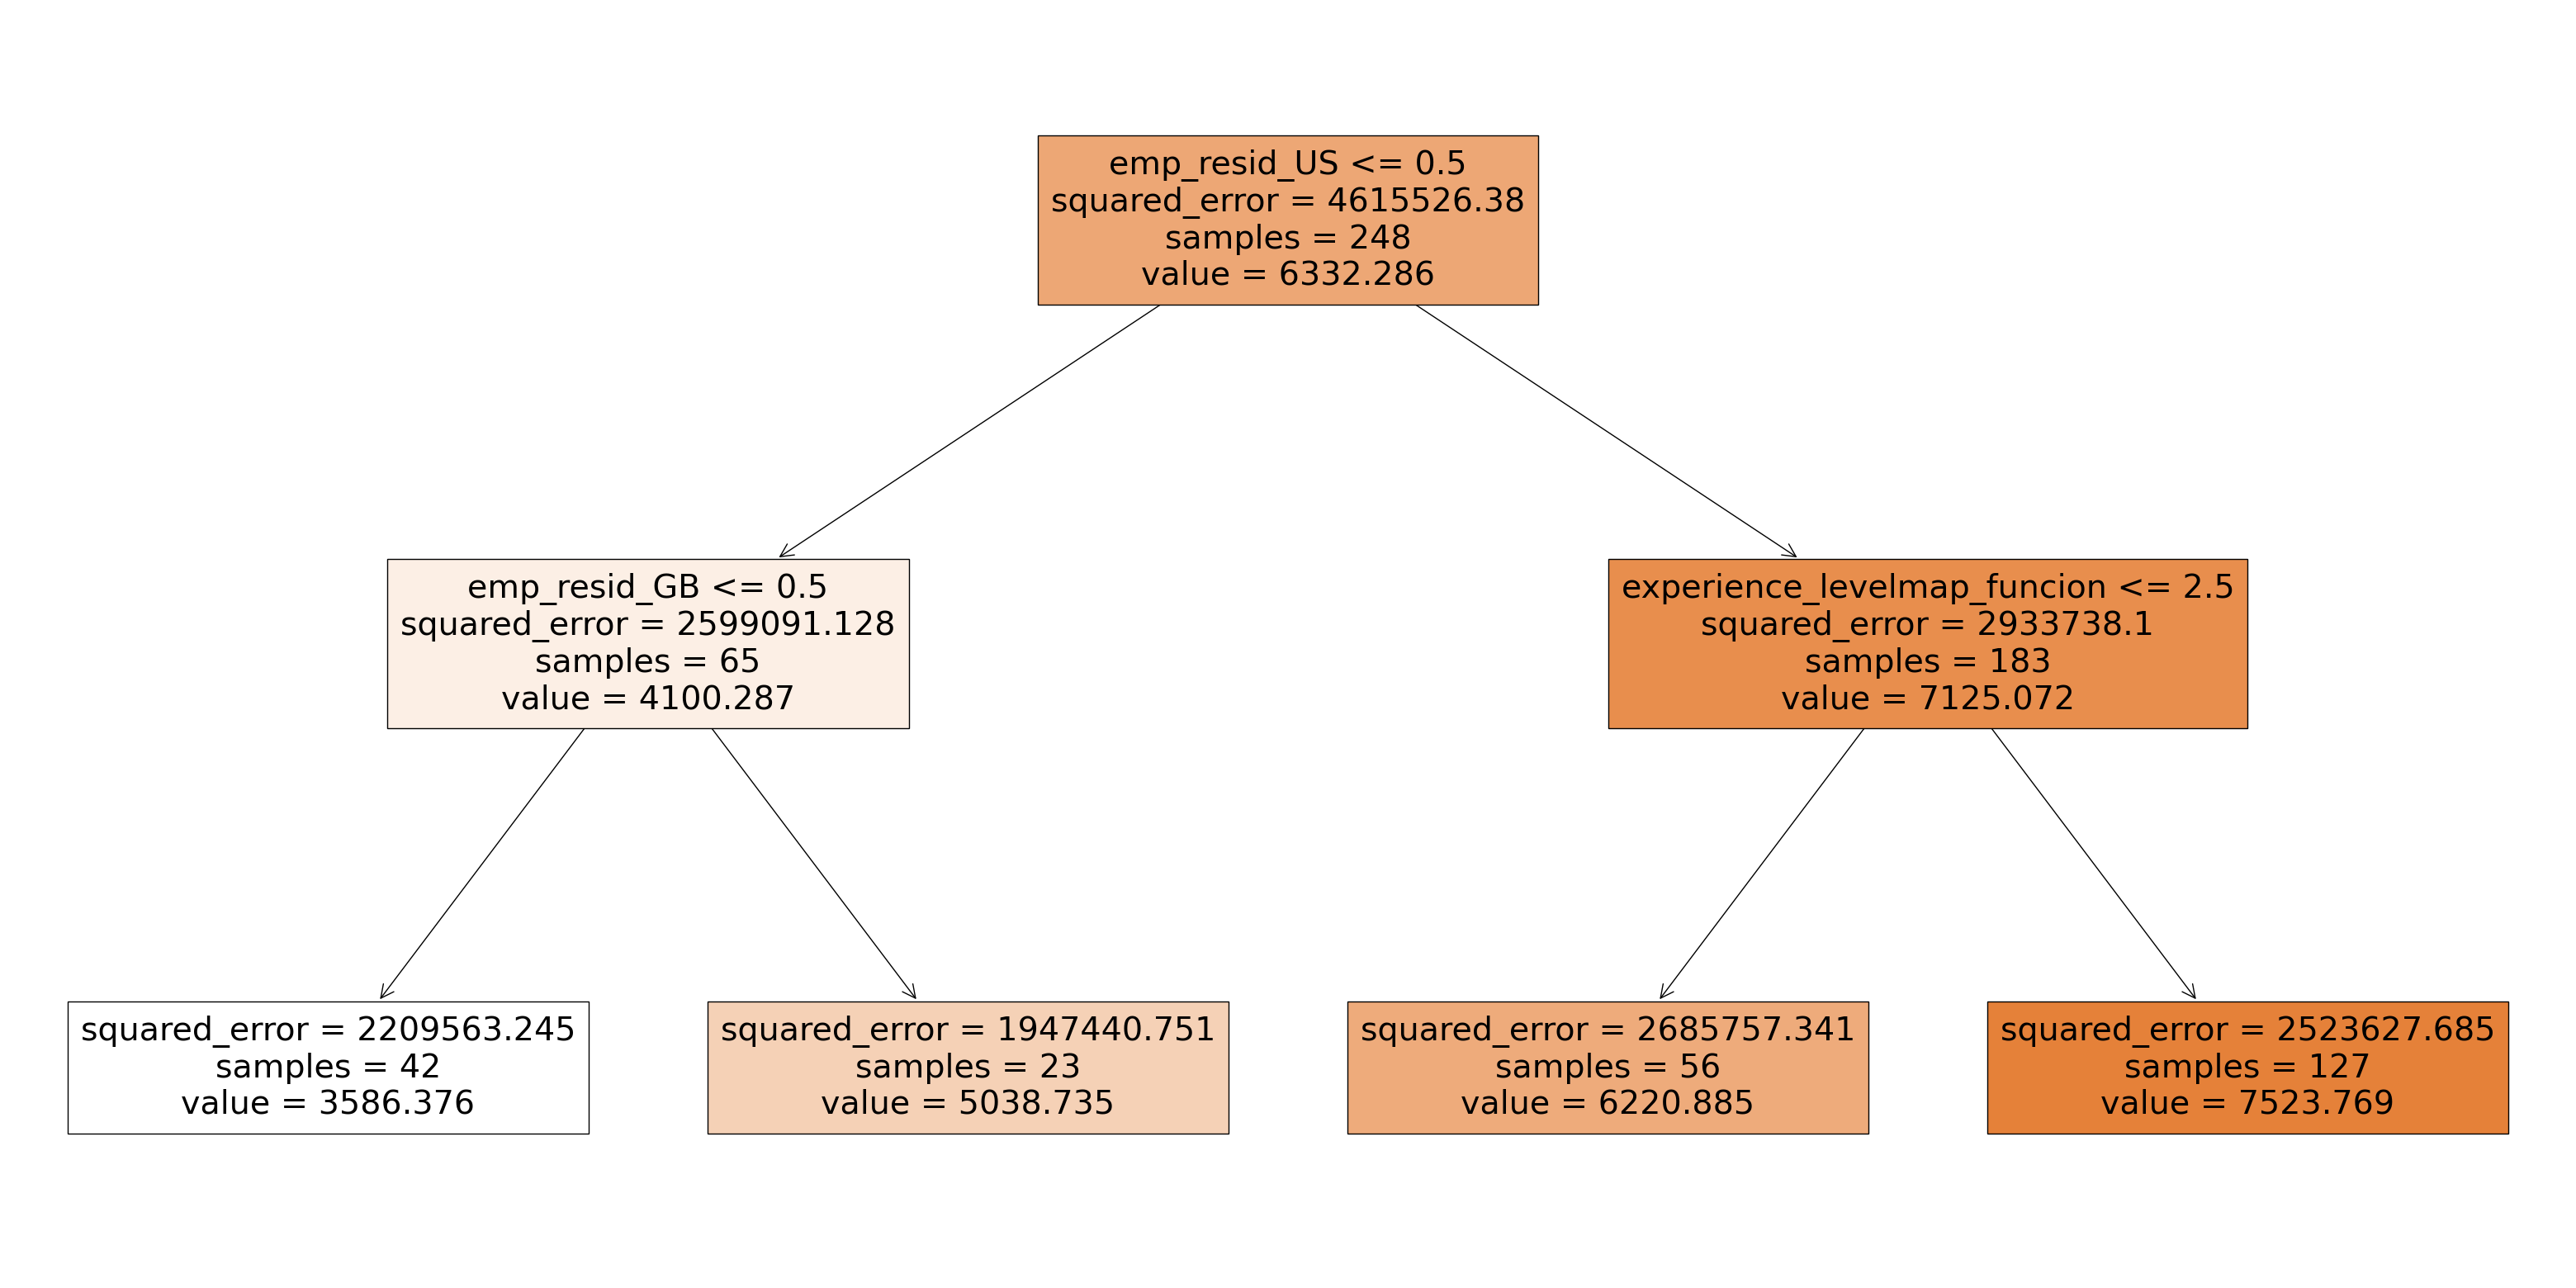

In [160]:
# veamos ahora que pinta tiene nuestro árbol


fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [161]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [162]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2


,MAE,MSE,RMSE,R2,set,modelo
0,1184.257035,2.373625e+06,1540.657356,0.392691,test,Decision tree II
1,1256.235880,2.453613e+06,1566.401157,0.468400,train,Decision tree II


In [163]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1120.693526,2.126582e+06,1458.280615,0.455898,test,Decission Tree I
1,1124.859940,2.063629e+06,1436.533616,0.552894,train,Decission Tree I
0,1184.257035,2.373625e+06,1540.657356,0.392691,test,Decision tree II
1,1256.235880,2.453613e+06,1566.401157,0.468400,train,Decision tree II


In [164]:
# si recodáis, en la clase de métricas guardamos en un csv los resultados de las métricas del modelo de regresión lineal
# hoy vamos a cargar ese csv y lo vamos a unir al dataframe que acabamos de crear con los resultados del decision tree para comparar las métricas

df_linear_results = pd.read_csv("../datos/resultados_salarys.csv", index_col = 0)
df_linear_results

,MAE,MSE,RMSE,R2,set,modelo
0,1074.127184,2.045892e+06,1430.346970,0.476543,test,Linear Regresion
1,1152.579168,2.117210e+06,1455.063529,0.541285,train,LinearRegression


In [165]:
# concatenamos todos los resultados

df_arbol_results = pd.concat([df_linear_results, df_decision_results], axis = 0)
df_arbol_results

,MAE,MSE,RMSE,R2,set,modelo
0,1074.127184,2.045892e+06,1430.346970,0.476543,test,Linear Regresion
1,1152.579168,2.117210e+06,1455.063529,0.541285,train,LinearRegression
0,1120.693526,2.126582e+06,1458.280615,0.455898,test,Decission Tree I
1,1124.859940,2.063629e+06,1436.533616,0.552894,train,Decission Tree I
0,1184.257035,2.373625e+06,1540.657356,0.392691,test,Decision tree II
1,1256.235880,2.453613e+06,1566.401157,0.468400,train,Decision tree II


In [166]:
# ademas vamos a guardar este dataframe en un csv para 

df_arbol_results.to_csv("../datos/resultados_salarys_tree.csv")

In [167]:

# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,emp_resid_US,0.818487
0,experience_levelmap_funcion,0.123045
4,emp_resid_GB,0.058468
1,emp_resid_CA,0.000000
2,emp_resid_ES,0.000000
3,emp_resid_FR,0.000000
5,emp_resid_IN,0.000000


Como podemos ver en los resultados obtenidos, vemos emp_resid_US concentra la mayor importancia. Si recordamos nuestro set de datos, esta variable concentraba muchísimas más muestras que las demás variables, e inferimos que este peso puede derivar de ahí. De esta manera, concluimos en que la diferencia muestral de cada variable tiene un impacto muy grande en nuestro modelo, por lo que tendríamos que plantearnos dividir nuestras muestras por continente, para poder hacer un modelo con número de muestras más igualadas. 

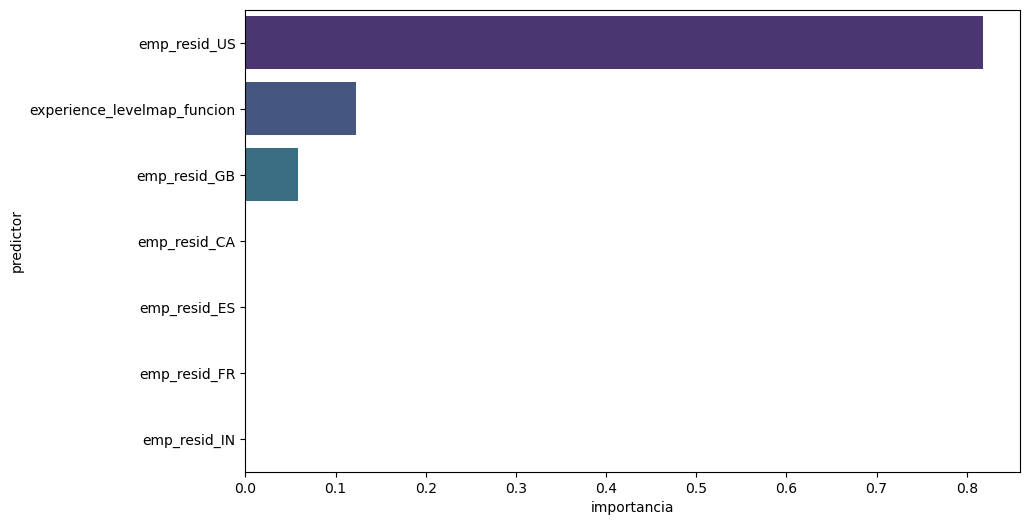

In [168]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()